## Multilabel classification with Logic Tensor Networks

This is a basic example in which we learn to ground unary predicates $A,B$ that are defined in the space of $[0,1]^2$.
We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$. $B$ is defined as the opposite of $A$ using data. It should hold for any point, for which $A$ does not hold. In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on whether their euclidian distance to $c$ is smaller than $.09$. We then define a number of facts for the predicate $A$. For all points that the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to. Similarly, we generate training data for $B$.
The basic theory/knowledgebase/model is
* we train $A$ on positive and negative data
* we train $B$ on positive and negative data
* $A$ and $B$ are disjoint. However, this is not an explicit axiom in the system. The disjointness is specified using positive/negative examples

In [1]:
import logging;logging.basicConfig(level=logging.INFO);
import numpy as np;
import matplotlib.pyplot as plt; 
import logictensornetworks_wrapper as ltnw;

Set the number of random training samples, the maximum number of epochs and how often we query the knowledgebase sat level in training.

In [2]:
nr_samples=500
max_epochs=10000
track_sat_levels=1000

Sample random data from $[0,1]^2$

In [3]:
data=np.random.uniform([0,0],[1.,1.],(nr_samples,2)).astype(np.float32)

Our groundtruth positive training data for A is close to the center (.5,.5). All other data is considered as positive example of $B$.

In [4]:
data_A=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)<.09)]
data_B=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)>=.09)]

We use three variables for feeding data to $A,B$. All points ($\mathrm{?data}$), points for which A is true ($\mathrm{?data\_A}$), points for which $B$ is true ($\mathrm{?data\_B}$).

In [5]:
ltnw.variable("?data",data);
ltnw.variable("?data_A",data_A);
ltnw.variable("?data_B",data_B);

Define the predicates $A,B$. $A,B$ have arity 1 (single argument) with 2 dimensions (since the domain is $[0,1]^2$)

In [6]:
ltnw.predicate("A",2);
ltnw.predicate("B",2);

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{?data\_A}$, $A$ should be true. For all points in $\mathrm{?data\_B}$, $B$ is true. For all points, iff  $A$ is true, $B$ is not true and vice versa.

In [7]:
ltnw.formula("forall ?data_A: A(?data_A)")
ltnw.formula("forall ?data_A: ~B(?data_A)")

ltnw.formula("forall ?data_B: B(?data_B)")
ltnw.formula("forall ?data_B: ~A(?data_B)")


print("\n".join(sorted(ltnw.FORMULAS.keys())))

forall ?data_A: A(?data_A)
forall ?data_A: ~B(?data_A)
forall ?data_B: B(?data_B)
forall ?data_B: ~A(?data_B)


Initialize the knowledgebase and train the knowledgebase.

In [8]:
ltnw.initialize_knowledgebase(initial_sat_level_threshold=.1)
sat_level=ltnw.train(track_sat_levels=1000,sat_level_epsilon=.99,max_epochs=20000)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.44911844
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.44911844
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> 0.52701443
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> 0.56921947
INFO:logictensornetworks_wrapper:TRAINING 3000 sat level -----> 0.61746097
INFO:logictensornetworks_wrapper:TRAINING 4000 sat level -----> 0.674079
INFO:logictensornetworks_wrapper:TRAINING 5000 sat level -----> 0.72858214
INFO:logictensornetworks_wrapper:TRAINING 6000 sat level -----> 0.77219987
INFO:logictensornetworks_wrapper:TRAINING 7000 sat level -----> 0.80415094
INFO:logictensornetworks_wrapper:TRAINING 8000 sat level -----> 0.8276554
INFO:logictensornetwork

We can now query the knowledgebase for various points in the domain.

In [9]:
ltnw.constant("a",[0.5,.5])
ltnw.constant("b",[0.75,.75])
print("a is in A: %s" % ltnw.ask("A(a)"))
print("b is in A: %s" % ltnw.ask("A(b)"))
print("a is in B: %s" % ltnw.ask("B(a)"))
print("b is in B: %s" % ltnw.ask("B(b)"))

a is in A: [0.9997192]
b is in A: [0.12289075]
a is in B: [0.00014211]
b is in B: [0.8925213]


We can check  if $A$ and $B$ are disjoint. We need to check whether for all points it is true that $A$ iff $B$.

In [10]:
ltnw.ask("forall ?data: A(?data) -> ~B(?data)")

array([0.9930101], dtype=float32)

In [11]:
ltnw.ask("forall ?data: B(?data) -> ~A(?data)")

array([0.9930101], dtype=float32)

In [16]:
ltnw.ask("forall ?data: ~A(?data) -> B(?data)")

array([0.9893036], dtype=float32)

In [17]:
ltnw.ask("forall ?data: ~B(?data) -> A(?data)")

array([0.9893036], dtype=float32)

These statements have a high satisfiability level -- so could be considered true. However, we tested this only on training data (using $\mathrm{?data}$). Let's see what is satisifiability level for randomly sampled test data. To check generalization, we sample new data $\mathrm{?test}$.

In [12]:
ltnw.variable("?test",np.random.uniform([0,0],[1.,1.],(400,2)).astype(np.float32))
ltnw.ask("forall ?test: A(?test) -> ~B(?test)")

array([0.99345905], dtype=float32)

In [13]:
ltnw.ask("forall ?test: B(?test) -> ~A(?test)",feed_dict={"?test" : np.random.uniform([0,0],[1.,1.],(400,2)).astype(np.float32)})

array([0.99306387], dtype=float32)

In [18]:
ltnw.ask("forall ?test: ~A(?test) -> B(?test)")

array([0.99210757], dtype=float32)

In [19]:
ltnw.ask("forall ?test: ~B(?test) -> A(?test)")

array([0.99210757], dtype=float32)

Visualize results for $A$ and $B$.

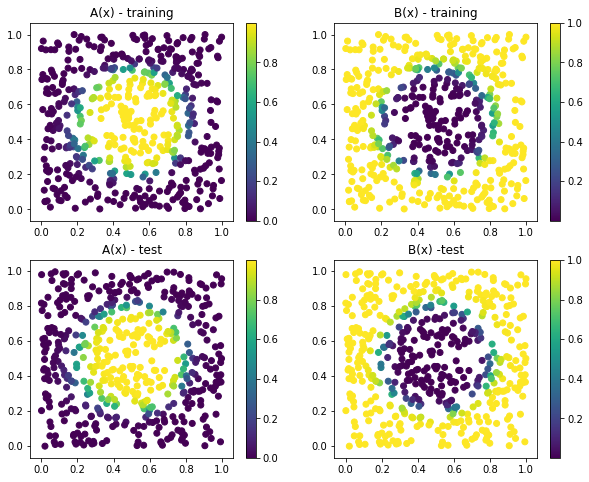

In [14]:
result=ltnw.ask("A(?data)")
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title("A(x) - training")
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()

plt.subplot(2,2,2)
result=ltnw.ask("B(?data)")
plt.title("B(x) - training")
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()

data_test=np.random.uniform([0,0],[1.,1.],(nr_samples,2)).astype(np.float32)
ltnw.variable("?data_test",data_test)
result=ltnw.ask("A(?data_test)")
plt.subplot(2,2,3)
plt.title("A(x) - test")
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze())
plt.colorbar()

result=ltnw.ask("B(?data_test)")
plt.subplot(2,2,4)
plt.title("B(x) -test")
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze())
plt.colorbar()

plt.show()